In [2]:
!pip install transformers torch einops --quiet
!pip install 'numpy<2' --quiet
!pip install tqdm pandas numpy scikit-learn --quiet
!pip install keras tensorflow --quiet
!pip install pyarrow matplotlib seaborn --quiet

In [3]:
import json
import re
import time
from ast import literal_eval
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers, models, optimizers, losses, callbacks
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tqdm.auto import tqdm
from transformers import AutoModel

2025-03-14 20:11:38.976934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df = pd.read_parquet(
    "hf://datasets/urvog/llama2_transcripts_healthcare_callcenter/data/train-00000-of-00001-643ef6d7d804c522.parquet")
df.head()

,text
0,<s>[INST] Classify the following call transcri...
1,<s>[INST] Classify the following call transcri...
2,<s>[INST] Classify the following call transcri...
3,<s>[INST] Classify the following call transcri...
4,<s>[INST] Classify the following call transcri...


In [5]:
text = str(df.iloc[0].text).replace("\n", "")
print(f"{text[:100]} [...]{text[-100:]}")

<s>[INST] Classify the following call transcript:Agent 3: Thank you for calling HealthHarbor, my nam [...] Have a great day!Agent 3: You too, Emma. Goodbye! [/INST] Medical Advice or Symptom Assessment </s>


In [6]:
def clean_and_extract_text(text):
    text = re.sub(r'<s>\[INST\] Classify the following call transcript:\n\n', '', text)
    match = re.search(r'\[/INST\] (.+?) </s>', text)
    if match:
        intent = match.group(1)
        text = text[:match.start()].strip()
    else:
        intent = None
    return text, intent


df[['cleaned_text', 'intent']] = df['text'].apply(lambda x: pd.Series(clean_and_extract_text(x)))

In [7]:
# Initialize and apply LabelEncoder
label_encoder = LabelEncoder()
df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

intent_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Intent mapping:", intent_mapping)

Intent mapping: {'Appointment Scheduling': 0, 'Follow-up Calls and Care Management': 1, 'General Inquiries': 2, 'Healthcare Facility Information': 3, 'Insurance and Billing Inquiries': 4, 'Lab and Test Results': 5, 'Medical Advice or Symptom Assessment': 6, 'Medical Records Requests': 7, 'Medication Refills and Prescription Inquiries': 8, 'Referrals and Specialist Appointments': 9}


In [8]:
# Check the distribution of intents in the dataset
intent_distribution = df['intent'].value_counts().reset_index()

print("Intent Distribution:")
print(intent_distribution)

Intent Distribution:
                                          intent  count
0                Insurance and Billing Inquiries    112
1                       Medical Records Requests    112
2                Healthcare Facility Information    111
3           Medical Advice or Symptom Assessment    102
4            Follow-up Calls and Care Management    100
5                           Lab and Test Results     97
6  Medication Refills and Prescription Inquiries     95
7          Referrals and Specialist Appointments     95
8                              General Inquiries     89
9                         Appointment Scheduling     87


In [9]:
def balance_dataset(df):
    min_count = df['intent'].value_counts().min()
    balanced_df = df.groupby('intent').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
    return balanced_df


balanced_df = balance_dataset(df)

# Shuffle the balanced dataset
balanced_df = shuffle(balanced_df, random_state=42)

/var/folders/fg/4670bf9x6q35chxf5pks3th00000gn/T/ipykernel_16397/1926966717.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('intent').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


In [10]:
# Split the data into training and temporary (which will be further split into validation and test)
train_df, temp_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df['intent'], random_state=42)

# Further split the temporary dataset into validation and test sets
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['intent'], random_state=42)

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(validation_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 609 samples
Validation set: 130 samples
Test set: 131 samples


In [11]:
# save the balanced dataframes
train_df.to_parquet('data/balanced_train_dataset.parquet', index=False)
validation_df.to_parquet('data/balanced_validation_dataset.parquet', index=False)
test_df.to_parquet('data/balanced_test_dataset.parquet', index=False)

In [12]:
# Extract intent counts from each dataset
train_counts = train_df['intent'].value_counts()
validation_counts = validation_df['intent'].value_counts()
test_counts = test_df['intent'].value_counts()

# Create a DataFrame to print a table with the distribution data
distribution_df = pd.DataFrame({
    'Intent': train_counts.index,
    'Training Count': train_counts.values,
    'Validation Count': validation_counts.reindex(train_counts.index, fill_value=0).values,
    'Test Count': test_counts.reindex(train_counts.index, fill_value=0).values
})
distribution_df.head(20)

,Intent,Training Count,Validation Count,Test Count
0,Medication Refills and Prescription Inquiries,61,13,13
1,Lab and Test Results,61,13,13
2,Appointment Scheduling,61,13,13
3,Healthcare Facility Information,61,13,13
4,Follow-up Calls and Care Management,61,13,13
5,Referrals and Specialist Appointments,61,13,13
6,Insurance and Billing Inquiries,61,13,13
7,Medical Records Requests,61,13,13
8,General Inquiries,61,13,13
9,Medical Advice or Symptom Assessment,60,13,14


In [13]:
# Let's start with embeddings
EMBEDDING_MODEL_NAME = "jinaai/jina-embeddings-v3"
embedding_model = AutoModel.from_pretrained(EMBEDDING_MODEL_NAME, trust_remote_code=True)

In [14]:
tqdm.pandas()


def embed_text(text: str, model) -> list[float]:
    """Generates embeddings for a given text using the provided model."""
    # You can customize the task as needed: 'retrieval.query', 'retrieval.passage', 'classification', etc.
    embeddings = model.encode(text, task="classification")
    return embeddings


def create_embeddings(model, df):
    df['embeddings'] = df['cleaned_text'].progress_apply(lambda text: embed_text(text, model))
    return df

In [15]:
DATA_PATH = 'data/'

train_path = Path(DATA_PATH) / 'call_center_train.csv'
test_path = Path(DATA_PATH) / 'call_center_test.csv'

if not train_path.exists():
    df_train = create_embeddings(embedding_model, train_df)
    df_train['embeddings'] = df_train['embeddings'].apply(lambda emb: json.dumps(emb.tolist()))
    df_train.to_csv(train_path, index=False)

if not test_path.exists():
    df_test = create_embeddings(embedding_model, test_df)
    df_test['embeddings'] = df_test['embeddings'].apply(lambda emb: json.dumps(emb.tolist()))
    df_test.to_csv(test_path, index=False)

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train["embeddings"] = df_train.embeddings.apply(literal_eval).apply(np.array)
df_test["embeddings"] = df_test.embeddings.apply(literal_eval).apply(np.array)

df_train['intent'] = df_train['intent'].astype('category')
df_test['intent'] = df_test['intent'].astype('category')

df_train.head()

  0%|          | 0/609 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

,text,cleaned_text,intent,intent_encoded,embeddings
0,<s>[INST] Classify the following call transcri...,"Agent 1: Thank you for calling HealthHarbor, m...",Medication Refills and Prescription Inquiries,8,"[0.02655057981610298, -0.060621410608291626, 0..."
1,<s>[INST] Classify the following call transcri...,Agent 3: Thank you for calling HealthHarbor. M...,Medication Refills and Prescription Inquiries,8,"[0.0647379606962204, -0.06422194838523865, 0.0..."
2,<s>[INST] Classify the following call transcri...,"Agent 4: Thank you for calling HealthHarbor, m...",Medical Advice or Symptom Assessment,6,"[0.06798619776964188, -0.07850642502307892, 0...."
3,<s>[INST] Classify the following call transcri...,[Phone ringing]\n\nAgent 3: Thank you for call...,Lab and Test Results,5,"[0.08077985048294067, -0.09275665879249573, 0...."
4,<s>[INST] Classify the following call transcri...,"Agent 1: Thank you for calling HealthHarbor, m...",Medication Refills and Prescription Inquiries,8,"[0.05675521120429039, -0.08665388822555542, 0...."


In [16]:
def build_and_compile_nn_classification_model(input_size: int, num_classes: int) -> models.Model:
    inputs = layers.Input(shape=(input_size,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    model.compile(
        loss=losses.SparseCategoricalCrossentropy(),
        optimizer=optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model


embedding_size = len(df_train['embeddings'].iloc[0])
num_classes = len(df_train['intent'].unique())
nn_classifier = build_and_compile_nn_classification_model(embedding_size, num_classes)
nn_classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,490 (517.54 KB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the neural network classifier

x_train = np.stack(df_train['embeddings'])
y_train = df_train['intent_encoded']

x_val = np.stack(df_test['embeddings'])
y_val = df_test['intent_encoded']

start_time = time.time()
callback = callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = nn_classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=20,
    callbacks=[callback],
    verbose=0
)
training_time_nn = time.time() - start_time
print(f"Neural Network Training Time: {training_time_nn:.4f} seconds")

Neural Network Training Time: 3.7461 seconds


In [18]:
# Evaluate model performance
nn_classifier.evaluate(x=x_val, y=y_val, return_dict=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8704 - loss: 0.6369 


{'accuracy': 0.8702290058135986, 'loss': 0.660179615020752}

In [19]:
# Evaluate the model's performance using scikit-learn's classification report and accuracy score

# Predict the class probabilities on the validation set
y_pred_probs = nn_classifier.predict(x_val)

# Use np.argmax to convert the predicted probabilities to class labels (for multi-class classification)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy_nn = accuracy_score(y_val, y_pred)
report_nn = classification_report(y_val, y_pred)

print("Neural Network Classifier:")
print(f"Accuracy: {accuracy_nn:.4f}")
print("Classification Report:")
print(report_nn)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Neural Network Classifier:
Accuracy: 0.8702
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       0.92      0.85      0.88        13
           2       0.55      0.46      0.50        13
           3       0.73      0.62      0.67        13
           4       1.00      1.00      1.00        13
           5       0.93      1.00      0.96        13
           6       0.88      1.00      0.93        14
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        13
           9       0.91      0.77      0.83        13

    accuracy                           0.87       131
   macro avg       0.87      0.87      0.86       131
weighted avg       0.87      0.87      0.86       131



In [20]:
# Random forest classifier

# Set up the training and testing data
X_train = df_train["embeddings"].to_list()  # Embeddings as input features
y_train = df_train["intent_encoded"].values  # Encoded label as target

X_test = df_test["embeddings"].to_list()  # Test embeddings as input features
y_test = df_test["intent_encoded"].values  # Test encoded labels as target

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

start_time = time.time()
rf_classifier.fit(X_train, y_train)
training_time_rf = time.time() - start_time
print(f"Random Forest Training Time: {training_time_rf:.4f} seconds")

# Generate and print classification report
predictions = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, predictions)
report_rf = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy_rf:.4f}")
print(report_rf)

Random Forest Training Time: 1.5618 seconds
Accuracy: 0.8702
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.91      0.77      0.83        13
           2       0.62      0.62      0.62        13
           3       0.80      0.62      0.70        13
           4       1.00      1.00      1.00        13
           5       0.87      1.00      0.93        13
           6       0.88      1.00      0.93        14
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        13
           9       0.91      0.77      0.83        13

    accuracy                           0.87       131
   macro avg       0.87      0.87      0.87       131
weighted avg       0.87      0.87      0.87       131



In [21]:
def calculate_centroids(df):
    """
    Calculates the centroid (mean embedding) for each class in the DataFrame.
    Returns a dictionary mapping class names to their centroid embeddings.
    """
    centroids = {}
    for class_name, group in df.groupby('intent'):
        embeddings = np.stack(group['embeddings'].values)
        centroid = np.mean(embeddings, axis=0)
        centroids[class_name] = centroid
    return centroids


# Calculate centroids from the training data
start_time = time.time()
centroids = calculate_centroids(df_train)
centroid_calculation_time = time.time() - start_time
print(f"Calculation Time: {centroid_calculation_time:.4f} seconds")

# Print centroids for each category
for class_name, centroid in centroids.items():
    print(f"Centroid for class {class_name}: {centroid}")

Calculation Time: 0.0102 seconds
Centroid for class Appointment Scheduling: [ 0.07923799 -0.0905649   0.06176326 ...  0.00396238 -0.04266151
  0.01572825]
Centroid for class Follow-up Calls and Care Management: [ 0.07604393 -0.09897032  0.05587162 ...  0.00363681 -0.04092639
  0.0239544 ]
Centroid for class General Inquiries: [ 0.07481919 -0.10421791  0.05958419 ...  0.00064528 -0.04272183
  0.01672489]
Centroid for class Healthcare Facility Information: [ 0.0745993  -0.10853212  0.06290775 ...  0.00072947 -0.04138453
  0.01642577]
Centroid for class Insurance and Billing Inquiries: [ 0.05456324 -0.08028025  0.04291892 ...  0.00078011 -0.04024098
  0.01736597]
Centroid for class Lab and Test Results: [ 0.07288429 -0.09751504  0.05158934 ... -0.0019883  -0.03356001
  0.02247676]
Centroid for class Medical Advice or Symptom Assessment: [ 0.06783654 -0.10146854  0.04876916 ...  0.00821037 -0.04468104
  0.00635389]
Centroid for class Medical Records Requests: [ 0.07963754 -0.10953711  0.06

/var/folders/fg/4670bf9x6q35chxf5pks3th00000gn/T/ipykernel_16397/4022202418.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for class_name, group in df.groupby('intent'):


In [23]:
from sklearn.metrics.pairwise import cosine_similarity

def predict_centroid(X_test, centroids):
    """
    Predicts classes for test samples using centroid-based classification.

    Args:
        X_test (np.array): Test embeddings.
        centroids (dict): Class centroids.

    Returns:
        np.array: Predicted class indices.
    """
    centroid_matrix = np.vstack(list(centroids.values()))
    predictions = []

    for embedding in X_test:
        embedding = embedding.reshape(1, -1)
        similarities = cosine_similarity(embedding, centroid_matrix)[0]
        best_index = np.argmax(similarities)
        predictions.append(best_index)

    return np.array(predictions)


start_time = time.time()
y_pred_centroid_indices = predict_centroid(X_test, centroids)
prediction_time_centroid = time.time() - start_time

class_names_list = list(centroids.keys())
predicted_class_names = [class_names_list[idx] for idx in y_pred_centroid_indices]
predicted_encoded_labels = [df_test['intent'].cat.categories.get_loc(name) for name in predicted_class_names]

# Compute evaluation metrics
accuracy_centroid = accuracy_score(y_test, predicted_encoded_labels)
report_centroid = classification_report(y_test, predicted_encoded_labels, target_names=df_test['intent'].cat.categories)

print("Centroid-Based Classifier:")
print(f"Prediction Time: {prediction_time_centroid:.4f} seconds")
print(f"Accuracy: {accuracy_centroid:.4f}")
print("Classification Report:")
print(report_centroid)

Centroid-Based Classifier:
Prediction Time: 0.0786 seconds
Accuracy: 0.8702
Classification Report:
                                               precision    recall  f1-score   support

                       Appointment Scheduling       0.86      0.92      0.89        13
          Follow-up Calls and Care Management       0.85      0.85      0.85        13
                            General Inquiries       0.64      0.54      0.58        13
              Healthcare Facility Information       0.75      0.69      0.72        13
              Insurance and Billing Inquiries       1.00      1.00      1.00        13
                         Lab and Test Results       0.93      1.00      0.96        13
         Medical Advice or Symptom Assessment       0.87      0.93      0.90        14
                     Medical Records Requests       1.00      1.00      1.00        13
Medication Refills and Prescription Inquiries       1.00      1.00      1.00        13
        Referrals and Speciali

In [24]:
test_data = validation_df[['cleaned_text', 'intent_encoded', 'intent']].to_dict(orient='records')

class_name_mapping = df_train['intent'].cat.categories


def predict_class_name_centroid(text, centroids, model):
    """ Classifies a sentence based on the closest centroid."""
    embedding = embed_text(text, model)

    # Stack centroids into a matrix
    centroid_matrix = np.vstack(list(centroids.values()))
    class_names = list(centroids.keys())

    # Calculate cosine similarity between the embedding and all centroids
    embedding = embedding.reshape(1, -1)  # Reshape embedding to (1, embedding_dim) for matrix multiplication
    similarities = cosine_similarity(embedding, centroid_matrix)[0]  # Get similarities for all centroids

    # Find the index of the centroid with the highest similarity
    best_index = np.argmax(similarities)

    # Get the predicted class name
    predicted_class = class_names[best_index]
    return predicted_class
    
def predict_class_name_nn(text, model, classifier):
    embedding = embed_text(text, model)
    predicted_output = classifier.predict(embedding.reshape(1, -1))
    predicted_class = np.argmax(predicted_output, axis=1)
    predicted_class_name = class_name_mapping[predicted_class[0]]
    return predicted_class_name


def predict_class_name_rf(text, model, classifier):
    embedding = embed_text(text, model)
    predicted_class = classifier.predict(embedding.reshape(1, -1))
    predicted_class_name = class_name_mapping[predicted_class[0]]
    return predicted_class_name


In [25]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Initialize an empty list to collect results
results = []

# Define a DataFrame for the results
columns = ['Text', 'Actual Intent', 'Predicted NN', 'Predicted RF', 'Predicted Centroid', 'Correct NN', 'Correct RF',
           'Correct Centroid']
results_df = pd.DataFrame(columns=columns)

# Process each entry in the test data
for entry in test_data:
    text = entry["cleaned_text"]
    actual_intent = entry["intent"]

    # Predictions
    predicted_class_name_nn = predict_class_name_nn(text, embedding_model, nn_classifier)
    predicted_class_name_rf = predict_class_name_rf(text, embedding_model, rf_classifier)
    predicted_class_name_centroid = predict_class_name_centroid(text, centroids, embedding_model)

    # Determine correctness
    correct_nn = '✅' if actual_intent == predicted_class_name_nn else '❌'
    correct_rf = '✅' if actual_intent == predicted_class_name_rf else '❌'
    correct_centroid = '✅' if actual_intent == predicted_class_name_centroid else '❌'

    # Append the result to the list
    results.append({
        'Text': text[:100],  # Show only first 100 characters
        'Actual Intent': actual_intent,
        'Predicted NN': predicted_class_name_nn,
        'Predicted RF': predicted_class_name_rf,
        'Predicted Centroid': predicted_class_name_centroid,
        'Correct NN': correct_nn,
        'Correct RF': correct_rf,
        'Correct Centroid': correct_centroid
    })

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results, columns=columns)

# Print the DataFrame with results
print(results_df.to_string(index=False))

# Generate a summary
summary = {
    'Classifier': ['NN', 'RF', 'Centroid'],
    'Total Predictions': [len(results_df)] * 3,
    'Correct Predictions': [
        results_df['Correct NN'].value_counts().get('✅', 0),
        results_df['Correct RF'].value_counts().get('✅', 0),
        results_df['Correct Centroid'].value_counts().get('✅', 0)
    ],
    'Accuracy': [
        results_df['Correct NN'].value_counts().get('✅', 0) / len(results_df),
        results_df['Correct RF'].value_counts().get('✅', 0) / len(results_df),
        results_df['Correct Centroid'].value_counts().get('✅', 0) / len(results_df)
    ]
}

summary_df = pd.DataFrame(summary)
print("\nSummary:")
print(summary_df.to_string(index=False))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━

In [26]:
test_data[0]["cleaned_text"]

"[Phone ringing]\n\nAgent 3: Thank you for calling HealthHarbor, my name is Agent 3. How can I assist you today?\n\nCustomer (angry): Finally! I've been on hold for ages! I need some information about your healthcare facility.\n\nAgent 3: I apologize for the wait, sir. I'll do my best to assist you. Could I please have your name?\n\nCustomer: It's John Smith.\n\nAgent 3: Thank you, Mr. Smith. How can I help you today?\n\nCustomer: I want to know what kind of medical services your hospital offers.\n\nAgent 3: HealthHarbor is a comprehensive healthcare facility that offers a wide range of medical services. We provide emergency care, surgeries, diagnostic imaging, laboratory services, and specialized treatments for various medical conditions.\n\nCustomer: Well, that's all fine and dandy, but what about the quality of your services? Are you guys any good?\n\nAgent 3: Absolutely, Mr. Smith. HealthHarbor is renowned for its high-quality care and patient satisfaction. We have a team of highly

In [27]:
text = test_data[0]["cleaned_text"]

start_time = time.time()
predicted_class_name_nn = predict_class_name_nn(text, embedding_model, nn_classifier)
prediction_time_nn = time.time() - start_time
print(f"Prediction Time: {prediction_time_nn:.4f} seconds")
print(f"Predicted class name: {predicted_class_name_nn}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction Time: 4.3578 seconds
Predicted class name: Healthcare Facility Information


In [28]:
start_time = time.time()
predicted_class_name_rf = predict_class_name_rf(text, embedding_model, rf_classifier)
prediction_time_rf = time.time() - start_time
print(f"Predicted class name: {predicted_class_name_rf}")
print(f"Prediction Time: {prediction_time_rf:.4f} seconds")

Predicted class name: Healthcare Facility Information
Prediction Time: 4.7152 seconds


In [29]:
start_time = time.time()
predicted_class_name_centroid = predict_class_name_centroid(text, centroids, embedding_model)
prediction_time_centroid = time.time() - start_time
print(f"The sentence is classified as: {predicted_class_name_centroid}")
print(f"Prediction Time: {prediction_time_centroid:.4f} seconds")

The sentence is classified as: Healthcare Facility Information
Prediction Time: 4.2274 seconds


In [30]:
comparison_df = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest', 'Centroid-Based'],
    'Training Time (s)': [training_time_nn, training_time_rf, centroid_calculation_time],
    'Prediction Time (s)': [prediction_time_nn, prediction_time_rf, prediction_time_centroid],
    'Accuracy': [accuracy_nn, accuracy_rf, accuracy_centroid]
})

print(comparison_df)

            Model  Training Time (s)  Prediction Time (s)  Accuracy
0  Neural Network           3.746068             4.357800  0.870229
1   Random Forest           1.561775             4.715214  0.870229
2  Centroid-Based           0.010195             4.227444  0.870229


/Users/patrick/Documents/ucb/wine_reviews/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


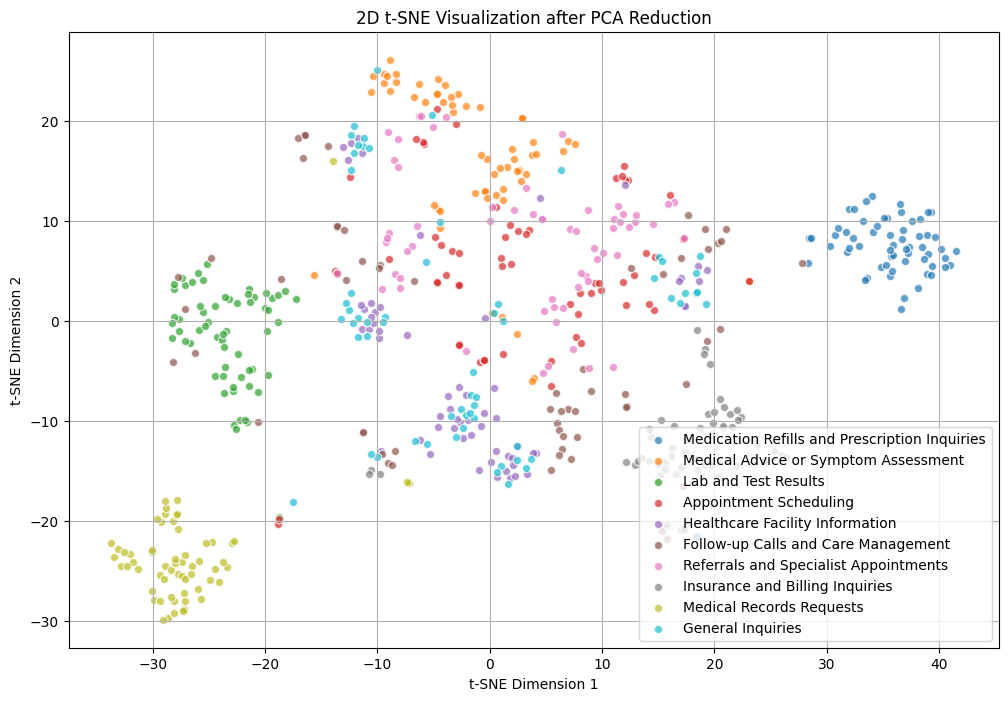

In [31]:
# Extract embeddings and labels
embeddings = np.array(df_train['embeddings'].tolist())
labels = df_train['intent']

# Perform PCA to reduce dimensions to a more manageable number (e.g., 50)
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Set perplexity to a value less than the number of samples
perplexity_value = min(30, len(embeddings_pca) - 1)

# Apply t-SNE on the PCA-reduced embeddings
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Create a color map for the classes
class_names = labels.unique()
color_map = {class_name: idx for idx, class_name in enumerate(class_names)}
colors = np.array([color_map[label] for label in labels])

# Plotting
plt.figure(figsize=(12, 8))

# Plot each class in a different color
for class_name in class_names:
    indices = np.where(labels == class_name)[0]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1],
                label=class_name,
                alpha=0.7,
                edgecolors='w')

plt.title('2D t-SNE Visualization after PCA Reduction')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()